In [3]:
import matplotlib.pyplot as pl
import pandas as pd
import rules.enzymes_v04 as enz
import numpy as np
enzymes = [item for item in dir(enz) if not item.startswith("__")]

pl.rcParams["font.family"] = "sans-serif"
pl.rcParams["font.size"] = 10

In [4]:
reports = ['v04_Rac1_dominant', 
           'v04_RhoA_dominant']

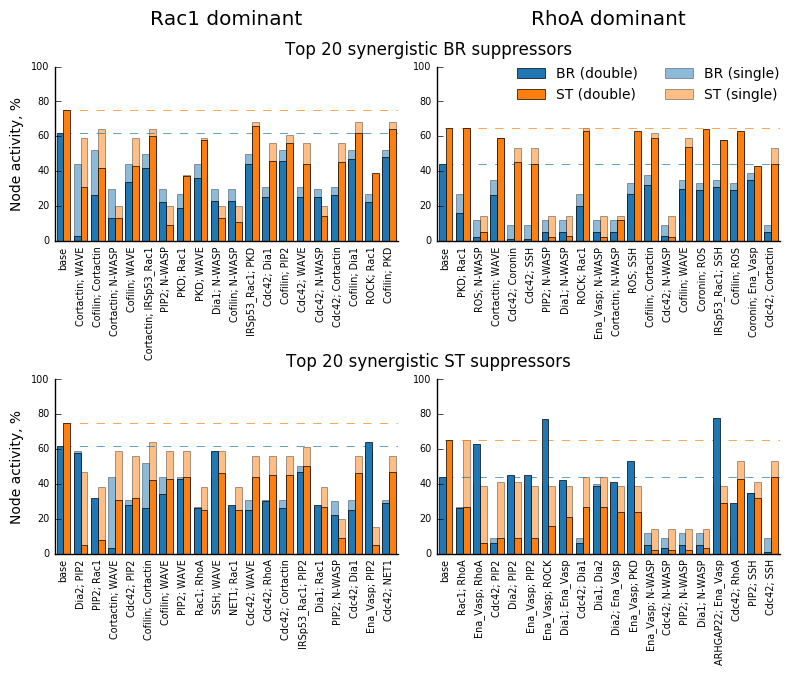

In [5]:
topX = 20

def get_single_kd_values(row, singles):    
    if row.name == 'base':
        return 0
    
    nodes = row.name.split('; ')
    return min(singles[nodes[0]], singles[nodes[1]])

  
def prepare_datasets(report):       
    df = pd.read_csv('reports/{}/summary.csv'.format(report), index_col=0)    
    df_single = df.filter(regex='^({0})$'.format('|'.join(enzymes))).loc[[enz.Actin_BR, enz.Actin_ST]]
    
    df = df.filter(regex='^(base|({0})_({0}))$'.format('|'.join(enzymes))).loc[[enz.Actin_BR, enz.Actin_ST]]
    df.columns = df.columns.str.replace(r'^({0})_({0})$'.format('|'.join(enzymes)), r'\g<1>; \g<2>').str.replace('WASP', 'N-WASP')
    df = df.transpose()
    
    base_BR = df['Actin_BR']['base']
    base_ST = df['Actin_ST']['base']
    
    df_single.columns = df_single.columns.str.replace('WASP', 'N-WASP')
    df_single = df_single.transpose()
        
    df['Actin_BR_single'] = df.apply(get_single_kd_values, axis=1, args=(df_single['Actin_BR'],))
    df['Actin_ST_single'] = df.apply(get_single_kd_values, axis=1, args=(df_single['Actin_ST'],))

    df['synergy_BR'] = df['Actin_BR'] - df['Actin_BR_single']
    df['synergy_ST'] = df['Actin_ST'] - df['Actin_ST_single']
                
    return [
            df[df.index == 'base'].append(
                df[(df['Actin_ST'] > 0) & (df['Actin_BR'] > 0)].sort_values('synergy_BR').head(topX)),
        
            df[df.index == 'base'].append(
                df[(df['Actin_ST'] > 0) & (df['Actin_BR'] > 0)].sort_values('synergy_ST').head(topX)
            )
        ]
    
def plot_knockdowns(dataframe, ax, maxn, with_y_label):
    colors = ['#1f77b4', '#ff7f0e']
    
    dataframe_single = dataframe[['Actin_BR_single', 'Actin_ST_single']].rename(
        columns={'Actin_BR_single': 'BR (single)', 'Actin_ST_single': 'ST (single)'})
    dataframe = dataframe[['Actin_BR', 'Actin_ST']].rename(
        columns={'Actin_BR': 'BR (double)', 'Actin_ST': 'ST (double)'})
    
    dataframe.plot.bar(width=0.8, color=colors,                               
                            ax=ax, legend=False, linewidth=0.5)
    
    dataframe_single.plot.bar(width=0.8, color=colors, 
                            ax=ax, legend=False, linewidth=0.5, zorder=-5, alpha=0.5)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_ticks_position('none')
    ax.xaxis.set_tick_params(labelsize='x-small')
    ax.yaxis.set_ticks_position('left')
    ax.yaxis.set_tick_params(labelsize='x-small')

    ax.set_ylim(top=100)
    if with_y_label:
        ax.set_ylabel('Node activity, %')
    ax.set_xlim(-0.5, maxn-0.5)
    
    br, st = dataframe.loc['base']
    ax.plot([-1, 100], [br, br], linewidth=0.5, linestyle='--', color=colors[0], zorder=-1)
    ax.plot([-1, 100], [st, st], linewidth=0.5, linestyle='--', color=colors[1], zorder=-1)
    
data = {}

for report in reports:
    data[report] = prepare_datasets(report)

row_titles = [
    r"Top %d synergistic BR suppressors" % topX,
    r"Top %d synergistic ST suppressors" % topX
]
        
fig, axis = pl.subplots(nrows=2, ncols=2, sharey=False, figsize=(8, 7))
for row in range(2):  
    for col in range(2):
        plot_knockdowns(data[reports[col]][row], axis[row][col], topX, with_y_label=(col==0))                
        
axis[0][0].set_title("Rac1 dominant", fontsize='x-large', y=1.2)
axis[0][1].set_title("RhoA dominant", fontsize='x-large', y=1.2)

axis[0][1].legend(loc='upper right', 
              ncol=2, 
              frameon=False, borderpad=0, borderaxespad=0,
              prop={'size':10})

for row, title in enumerate(row_titles):
    axis[row][1].text(-1, 107, title, fontsize='large', ha='center', 
                      bbox=dict(facecolor='white', edgecolor='none', pad=0))
          
pl.tight_layout()
            
# pl.savefig('charts/fig_5_top_20_synergy.png', bbox_inches='tight', dpi=300)
# pl.savefig('charts/fig_5_top_20_synergy.svg', bbox_inches='tight')
# pl.savefig('charts/fig_5_top_20_synergy.eps', bbox_inches='tight')

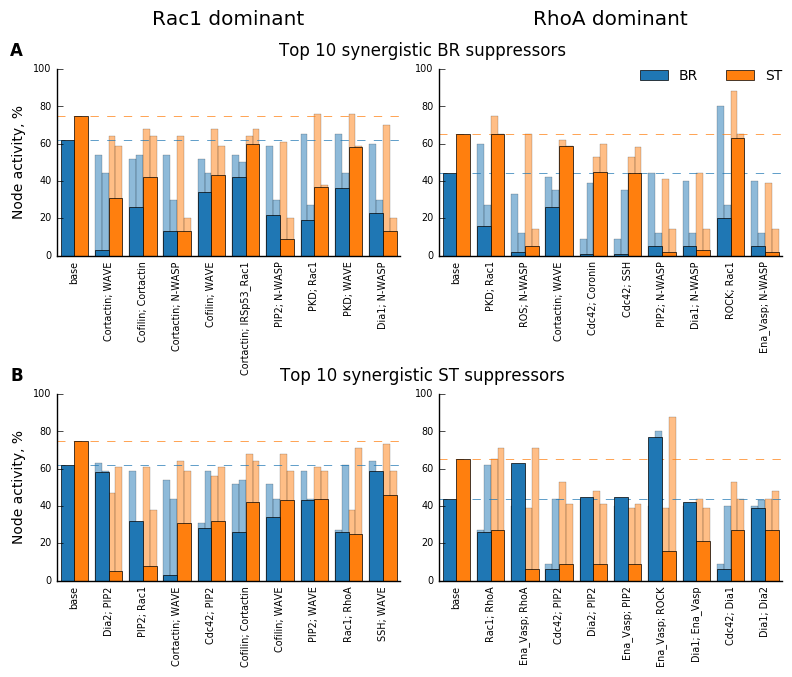

In [7]:
topX = 10

def get_single_kd_min_value(row, singles):    
    if row.name == 'base':
        return 0
    
    nodes = row.name.split('; ')
    return min(singles[nodes[0]], singles[nodes[1]])

def get_single_kd_value(row, singles, num):    
    if row.name == 'base':
        return 0
    
    nodes = row.name.split('; ')
    return singles[nodes[num]]

  
def prepare_datasets(report):       
    df = pd.read_csv('reports/{}/summary.csv'.format(report), index_col=0)    
    df_single = df.filter(regex='^({0})$'.format('|'.join(enzymes))).loc[[enz.Actin_BR, enz.Actin_ST]]
    
    df = df.filter(regex='^(base|({0})_({0}))$'.format('|'.join(enzymes))).loc[[enz.Actin_BR, enz.Actin_ST]]
    df.columns = df.columns.str.replace(r'^({0})_({0})$'.format('|'.join(enzymes)), r'\g<1>; \g<2>').str.replace('WASP', 'N-WASP')
    df = df.transpose()
    
    base_BR = df['Actin_BR']['base']
    base_ST = df['Actin_ST']['base']
    
    df_single.columns = df_single.columns.str.replace('WASP', 'N-WASP')
    df_single = df_single.transpose()
        
    df['Actin_BR_single'] = df.apply(get_single_kd_min_value, axis=1, args=(df_single['Actin_BR'],))
    df['Actin_ST_single'] = df.apply(get_single_kd_min_value, axis=1, args=(df_single['Actin_ST'],))
    
    df['Actin_BR_single_nodeA'] = df.apply(get_single_kd_value, axis=1, args=(df_single['Actin_BR'],0))
    df['Actin_BR_single_nodeB'] = df.apply(get_single_kd_value, axis=1, args=(df_single['Actin_BR'],1))
    
    df['Actin_ST_single_nodeA'] = df.apply(get_single_kd_value, axis=1, args=(df_single['Actin_ST'],0))
    df['Actin_ST_single_nodeB'] = df.apply(get_single_kd_value, axis=1, args=(df_single['Actin_ST'],1))
        

    df['synergy_BR'] = df['Actin_BR'] - df['Actin_BR_single']
    df['synergy_ST'] = df['Actin_ST'] - df['Actin_ST_single']
                
    return [
            df[df.index == 'base'].append(
                df[(df['Actin_ST'] > 0) & (df['Actin_BR'] > 0)].sort_values('synergy_BR').head(topX)),
        
            df[df.index == 'base'].append(
                df[(df['Actin_ST'] > 0) & (df['Actin_BR'] > 0)].sort_values('synergy_ST').head(topX)
            )
        ]
    
def plot_knockdowns(dataframe, ax, maxn, with_y_label):
    colors = ['#1f77b4', '#ff7f0e']
    
    dataframe_single = dataframe[['Actin_BR_single_nodeA', 'Actin_BR_single_nodeB',
                                  'Actin_ST_single_nodeA', 'Actin_ST_single_nodeB']]
    
    dataframe = dataframe[['Actin_BR', 'Actin_ST']].rename(
        columns={'Actin_BR': 'BR', 'Actin_ST': 'ST'})
    
    dataframe.plot.bar(width=0.8, color=colors,                               
                            ax=ax, legend=False, linewidth=0.5)
    
    
    ax.bar(np.arange(len(dataframe_single)) - 0.4, height=dataframe_single['Actin_BR_single_nodeA'], 
          width=0.2, color=colors[0], alpha=0.5, zorder=-5, linewidth=0.25)
    ax.bar(np.arange(len(dataframe_single)) - 0.2, height=dataframe_single['Actin_BR_single_nodeB'], 
          width=0.2, color=colors[0], alpha=0.5, zorder=-5, linewidth=0.25)
    ax.bar(np.arange(len(dataframe_single)) + 0.0, height=dataframe_single['Actin_ST_single_nodeA'], 
          width=0.2, color=colors[1], alpha=0.5, zorder=-5, linewidth=0.25)
    ax.bar(np.arange(len(dataframe_single)) + 0.2, height=dataframe_single['Actin_ST_single_nodeB'], 
          width=0.2, color=colors[1], alpha=0.5, zorder=-5, linewidth=0.25)
    

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_ticks_position('none')
    ax.xaxis.set_tick_params(labelsize='x-small')
    ax.yaxis.set_ticks_position('left')
    ax.yaxis.set_tick_params(labelsize='x-small')

    ax.set_ylim(top=100)
    if with_y_label:
        ax.set_ylabel('Node activity, %')
    ax.set_xlim(-0.5, maxn-0.5)
    
    br, st = dataframe.loc['base']
    ax.plot([-1, 100], [br, br], linewidth=0.5, linestyle='--', color=colors[0], zorder=-1)
    ax.plot([-1, 100], [st, st], linewidth=0.5, linestyle='--', color=colors[1], zorder=-1)
    
data = {}

for report in reports:
    data[report] = prepare_datasets(report)

row_titles = [
    r"Top %d synergistic BR suppressors" % topX,
    r"Top %d synergistic ST suppressors" % topX
]
        
fig, axis = pl.subplots(nrows=2, ncols=2, sharey=False, figsize=(8, 7))
for row in range(2):  
    for col in range(2):
        plot_knockdowns(data[reports[col]][row], axis[row][col], topX, with_y_label=(col==0))                
        
axis[0][0].set_title("Rac1 dominant", fontsize='x-large', y=1.2)
axis[0][1].set_title("RhoA dominant", fontsize='x-large', y=1.2)

axis[0][1].legend(loc='upper right', 
              ncol=2, 
              frameon=False, borderpad=0, borderaxespad=0,
              prop={'size':10})

for row, title in enumerate(row_titles):
    axis[row][1].text(-1, 107, title, fontsize='large', ha='center', 
                      bbox=dict(facecolor='white', edgecolor='none', pad=0))
    axis[row][0].text(-1.5, 107, chr(65+row), fontsize='large', ha='right', 
                      fontweight='bold')
          
pl.tight_layout()
            
pl.savefig('charts/fig_5_top_10_synergy_two_bars.png', bbox_inches='tight', dpi=300)
pl.savefig('charts/fig_5_top_10_synergy_two_bars.svg', bbox_inches='tight')
pl.savefig('charts/fig_5_top_10_synergy_two_bars.eps', bbox_inches='tight')

In [5]:
# del df
df = data['v04_Rac1_dominant'][2]

df[df['Actin_BR_single'] < df['Actin_BR']]


,Actin_BR,Actin_ST,Actin_BR_single,Actin_ST_single,synergy_BR,synergy_ST
base,62,75,0,0,62,75
ARHGAP22; CP,81,93,67,82,14,11
ARHGAP22; Cdc42,55,70,31,56,24,14
ARHGAP22; Cofilin,64,75,52,68,12,7
ARHGAP22; Coronin,77,79,63,71,14,8
ARHGAP22; Cortactin,61,67,54,64,7,3
ARHGAP22; Dia1,69,77,60,70,9,7
ARHGAP22; Dia2,74,46,63,47,11,-1
ARHGAP22; Ena_Vasp,74,15,63,15,11,0
ARHGAP22; IRSp53_Cdc42,76,83,63,76,13,7
